This file is to try SBI_SGM 

And I train model with a general connectome.


# import and define

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from tqdm import trange, tqdm

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import logging

In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from sbi_sgm import SBI_SGM
from spectrome import Brain
from sgm.sgm import SGM
from utils.standardize import psd_2tr, stdz_vec

# Load real data PSD and brain

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;

In [6]:
# define a SGM model
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
# brain.bi_symmetric_c()
# brain.reduce_extreme_dir()

# In fact you do not need the `Brain` class stuff, 
# if you prepared you own sc and dist matrices. 
sc_mat = brain.connectome
dist_mat = brain.distance_matrix
sgmmodel = SGM(sc_mat, dist_mat, FREQS);

# SBI-SGM class

In [16]:
# make it support to change prior !TODO
# make it support to give raw time series data in add data !TODO
# give the point estimation when generate modelled PSD !TODO
# get a visualization of the posterior sps !TODO
# make it support to multi-round training

In [7]:
# initial the SBI_SGM class
# sgmmodel: SGM class.
# save_folder: the folder you want to save the results to, str or bool, if True, it generates a default folder
# verbose: more output or not. if you feel the output info is annoying, set verbose=False
# num_prior_sps: the num of sps used to train SBI, 10,000 is a good starting point
# noise_sd: the noise sd added to SGM output, 0.2 is a good starting point 
# (num_prior_sps, noise_sd) are most inferential params in SBI_SGM
# other params for fitting sbi, refer to source file
sbi_sgm = SBI_SGM(sgmmodel, save_folder="test_sbisgm", verbose=1, num_prior_sps=1000, noise_sd=0.2);

2024-02-14 15:25:12,422 - sbi_sgm - INFO - In this class, the sgm parameter order is ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei'].
2024-02-14 15:25:12,423 - sbi_sgm - INFO - {'noise_sd': 0.2, 'num_prior_sps': 1000, 'den_est': 'nsf', 'is_embed': False, 'prior_sd': 10, 'k': 0.1, 'names': ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei'], 'prior_bds': array([[5.e-03, 3.e-02],
       [5.e-03, 2.e-01],
       [5.e-03, 3.e-02],
       [5.e+00, 2.e+01],
       [1.e-01, 1.e+00],
       [1.e-03, 2.e+00],
       [1.e-03, 7.e-01]])}
2024-02-14 15:25:12,428 - sbi_sgm - INFO - Results will be saved at /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../results/test_sbisgm.


In [8]:
# now you can fit the model
# load: if you have saved results, you can set load = true to load it
sbi_sgm.SBI_fit(load=False)
# sbi_sgm.SBI_fit()

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/notebooks/../mypkg/../results/test_sbisgm/posterior.pkl


In [11]:
# you add the psd data for inference 
# note that psd is not in dB, it is in linear (abs magnitude)
sbi_sgm.add_data(psd=ind_psd[:, :, 0]);

In [12]:
# Get the posterior samples of SGM parameters
# n: num of sps to draw
post_sps = sbi_sgm.get_post_sps(n=1000);

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/hujin/.local/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  outputs, _ = torch.triangular_solve(


In [13]:
# based on generated sgm parameters, get modeled psd 
# Now psd is in std dB
psd = sbi_sgm.get_model_psd();

In [14]:
# you can further get posterior PSD (in std dB)
# n: num of sps to draw
post_psd_sps = sbi_sgm.get_post_psd_sps(n=10);

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
# TODO: add harmonic

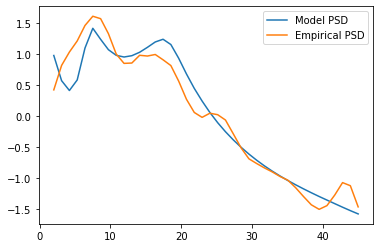

In [15]:
plt.plot(FREQS, stdz_vec(psd.mean(axis=0)), label="Model PSD")
plt.plot(FREQS, stdz_vec(psd_2tr(ind_psd[:, :, 0]).mean(axis=0)), label="Empirical PSD")
plt.legend()